In [2]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
#%matplotlib inline

### Function library:

##### Function to read the file, filter for needed columns, adjusted date formatting, and sorting the dates to ensure correct order:

In [3]:
def setupDf(file):
    df = pd.read_csv(file)
    df= df[['Date(UTC)','eth_etherprice']]
    df['Date(UTC)'] = pd.to_datetime(df.iloc[:,0])
    df.sort_values(by='Date(UTC)')
    return df

##### Function to setup the feature columns based on number of days to look back, and lookback type (immediate vs window):

In [4]:
def setupcolumns(df, dfpricecolumn, prevdays, feats):  
    df1 = df.copy()
    df1 = df1[df1.eth_etherprice != 0]
    #adding columns for log price, tomorrows return, and if it is positive or negative (includes 0 as positive, since not losing)
    df1['logethprice'] = np.log(df1.eth_etherprice)
    df1['tomorrowReturn'] = np.log(df1.eth_etherprice.shift(-1))-np.log(df1.eth_etherprice.shift(0))
    df1['tomorrowPosNeg'] = np.log(df1.eth_etherprice.shift(-1))-np.log(df1.eth_etherprice.shift(0)) >= 0
    
    #Immediate day prior lookback (return always relative to the day prior)
    if feats == 0 or feats == 2:
        for i in range(0,prevdays):
            colname = 'return_'+str(i+1)+'prior'
            df1[colname] = np.log(df1.eth_etherprice.shift(i))-np.log(df1.eth_etherprice.shift(i+1))

    #Window lookbacks (return is relative to the price 'prevdays' back)
    if feats == 1 or feats == 2:
        for i in range(0,prevdays):
            colname = 'return_'+str(i+1)+'lookback'
            df1[colname] = np.log(df1.eth_etherprice) - np.log(df1.eth_etherprice.shift(i+1))    
     
    df1 = df1.replace([np.inf,-np.inf],np.nan)
    df1 = df1.dropna()   
    return df1

##### Function to run the algorithm on the dataset. Allows choice of KNN or LogisticRegression, with the option to select # of neighbors and whether it is scaled with StandardScaler or not:

In [5]:
def runAlgo(df, algo, parameter, scaled=0):
    df_train, df_test = df.iloc[:len(df)/2], df[len(df)/2:]
    X_train, y_train = df_train[df_train.columns.drop(['Date(UTC)','eth_etherprice','logethprice','tomorrowReturn','tomorrowPosNeg'])], df_train['tomorrowPosNeg']
    X_test, y_test = df_test[df_test.columns.drop(['Date(UTC)','eth_etherprice','logethprice','tomorrowReturn','tomorrowPosNeg'])], df_test['tomorrowPosNeg']

    if algo == 'KNN':
        if scaled == 1:
            mypipeline = Pipeline([
                ('myScaler', StandardScaler()),
                ('masterAlg', KNeighborsClassifier(n_neighbors=parameter))
            ])
        else: 
            mypipeline = Pipeline([
                ('masterAlg', KNeighborsClassifier(n_neighbors=parameter))
            ])
    elif algo == 'LR':
        if scaled == 1:
            mypipeline = Pipeline([
                ('myScaler', StandardScaler()),
                ('masterAlg', LogisticRegression())
            ])
        else: 
            mypipeline = Pipeline([
                ('masterAlg', LogisticRegression())
            ])
        
    mypipeline.fit(X_train, y_train)
    y_pred = mypipeline.predict(X_test)
    y_predproba = mypipeline.predict_proba(X_test)

    results = np.vstack([[y_test,y_pred,y_predproba[:,0]]])
    return results.transpose() 

##### Function that takes the dataset being analyzed and the results output by the model, and computes what the final net worth would be at the end of trading the test set

In [6]:
def tradeAnalysis(df, results, usd=1000, pred=1):
    dfcompare = df[['Date(UTC)','eth_etherprice','tomorrowReturn','tomorrowPosNeg']].copy()
    dfcompare = dfcompare[len(dfcompare)/2:].copy()
    dfcompare['tomorrowPredicted'] = results[:,1]
    usd = float(1000)
    ethshare = float(0)
    for i in range(0,len(dfcompare)):
        if i == 0:
            ethshare = usd/dfcompare['eth_etherprice'].iloc[i]
            usd=0
        else:
            if dfcompare.tomorrowPredicted.iloc[i] == True and usd > 0:
                ethshare = usd/dfcompare['eth_etherprice'].iloc[i]
                usd = 0
            elif dfcompare.tomorrowPredicted.iloc[i] == False and ethshare > 0:
                usd = ethshare*dfcompare['eth_etherprice'].iloc[i]
                ethshare = 0
    
    if usd==0:
        usd = ethshare*dfcompare['eth_etherprice'].iloc[len(dfcompare)-1]
    
    return float(usd)

##### Function that takes the test set and predicted values as inputs and output the performance metrics with column labels to identify the different parameters 

In [7]:
def performanceAnalysis(df, results, algo, parameter, scaled, prevdays, feats):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(results[:,0], results[:,1]).ravel()
    tpr = float(tp)/(tp + fn)
    tnr = float(tn)/(tn + fp)
    ppr = float(tp)/(tp + fp)
    npr = float(tn)/(tn + fn)
    accuracy = float(tp+tn)/(tp+tn+fp+fn)
    f1 = 2.0/(1.0/tpr + 1.0/ppr)
    networth = tradeAnalysis(df, results)
    
    columns = ['Algorithm','Parameter','Scaled','PrevDays','FeatsType','True Positives Rate','True Negatives Rate',
               'Positive Predicted Rate','Negative Predicted Rate','F1 Score','Accuracy','Net Worth']
    perfmetrics = pd.DataFrame(data=[[algo,parameter,scaled,prevdays,feats,
                                      tpr,tnr,ppr,npr,f1,accuracy,networth]],columns=columns )
    return perfmetrics
    #return networth

##### Function compares the daily fluctuations of market growth (if you buy and hold until th last day of test) to a particular algorithm that is input

In [8]:
def marketReturnDailyCompare(df, algo, parameter, scaled, prevdays, feats):
    dfcompare = setupcolumns(df, df.eth_etherprice, prevdays, feats)
    
    results = runAlgo(dfcompare,algo,parameter,scaled)
    dfcompare = dfcompare[['Date(UTC)','eth_etherprice','tomorrowReturn','tomorrowPosNeg']].copy()
    dfcompare = dfcompare[len(dfcompare)/2:].copy()
    dfcompare['tomorrowPredicted'] = results[:,1]
    dfcompare['Market Value'] = 0
    dfcompare['Algo Value'] = 0
           
    usd = float(1000)
    ethshare = float(0)
    for i in range(0,len(dfcompare)):
        if i == 0:
            dfcompare['Market Value'].iloc[i] = float(1000)
            dfcompare['Algo Value'].iloc[i] = usd
            ethshare = usd/dfcompare['eth_etherprice'].iloc[i]
            usd=0
        else:
            dfcompare['Market Value'].iloc[i] = dfcompare['Market Value'].iloc[i-1]*np.exp(dfcompare.tomorrowReturn.iloc[i-1])
            if dfcompare.tomorrowPredicted.iloc[i] == True and usd > 0:
                dfcompare['Algo Value'].iloc[i]==usd
                ethshare = usd/dfcompare['eth_etherprice'].iloc[i]
                usd = 0
            elif dfcompare.tomorrowPredicted.iloc[i] == True and ethshare > 0:
                dfcompare['Algo Value'].iloc[i] = ethshare * dfcompare['eth_etherprice'].iloc[i]
            elif dfcompare.tomorrowPredicted.iloc[i] == False and ethshare > 0:
                usd = ethshare*dfcompare['eth_etherprice'].iloc[i]
                ethshare = 0
                dfcompare['Algo Value'].iloc[i] = usd
            elif dfcompare.tomorrowPredicted.iloc[i] == False and usd > 0:
                dfcompare['Algo Value'].iloc[i] = usd

    return dfcompare

##### Master function that calls the other functions and iterates through various parameter combinations, outputting the results in an organized dataframe

In [9]:
def performanceTable(df, algo, parameter, prevdays, feats):
    columns = ['Algorithm','Parameter','Scaled','PrevDays','FeatsType','True Positives Rate',
               'True Negatives Rate','Positive Predicted Rate','Negative Predicted Rate','F1 Score','Accuracy','Net Worth']
    resultsTable = pd.DataFrame(columns = columns)

    df1 = setupcolumns(df, df.eth_etherprice, prevdays, feats)
    
    if algo == 'KNN':
        for i in range(1,parameter+1,2):
            for j in range(0,2):
                results = runAlgo(df1, algo, parameter=i, scaled=j)
                performance = performanceAnalysis(df1, results, algo, i, j, prevdays, feats)
                resultsTable = resultsTable.append(performance)
    
    if algo == 'LR':
        for i in range(0,2):
            results = runAlgo(df1, 'LR', parameter=0, scaled=i)
            performance = performanceAnalysis(df1, results, algo,'---',i, prevdays, feats)
            resultsTable = resultsTable.append(performance)
    return resultsTable
    #return performance

### Analysis Questions:

#####  Generating a master table of algorithm combinations based on the algorithm, the type of lookback window, number of days to look back, scaled or not scaled, and number of neighbors for KNN:

In [9]:
fullMasterTable = pd.DataFrame()
for feat in range(0,3):
    df = setupDf('ethereum_dataset.csv')
    for days in range(1,25):
        fullMasterTable = fullMasterTable.append(performanceTable(df,'KNN',parameter=50,prevdays=days,feats=feat))
        fullMasterTable = fullMasterTable.append(performanceTable(df,'LR',parameter='---',prevdays=days,feats=feat))

#### - Results for Logisitic Regression 
##### Model based on 10 day lookback of immediate day prior returns, showing performance for both scaled and not scaled: 

In [12]:
lr10day = fullMasterTable.loc[(fullMasterTable.Algorithm=='LR')&(fullMasterTable.PrevDays==10)&(fullMasterTable.FeatsType==0)]
lr10day.sort_values(by='Net Worth', ascending=False)

,Algorithm,Parameter,Scaled,PrevDays,FeatsType,True Positives Rate,True Negatives Rate,Positive Predicted Rate,Negative Predicted Rate,F1 Score,Accuracy,Net Worth
0,LR,---,0,10,0,0.873171,0.159204,0.514368,0.551724,0.647378,0.519704,9654.973040
0,LR,---,1,10,0,0.765854,0.283582,0.521595,0.542857,0.620553,0.527094,6138.315107


There is less to analyze for the standard 10-day look back with Logistic Regression alone, since I only looked it with scaled and unscaled values. Regardless, the correlation matrix below shows the positive correlation between 'Net Worth' and 'F1 Score', 'Negative Predicted Rate', and 'True Positives Rate'

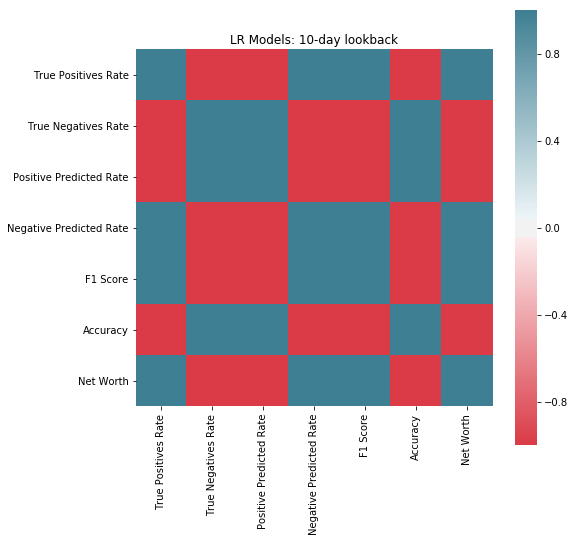

In [13]:
corr = lr10day.corr()
fig,fax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, cmap = sns.diverging_palette(10,220,as_cmap=True),
           square=True,
           ax=fax)
plt.title('LR Models: 10-day lookback')
plt.show()

### - Results for KNN model 
##### Based on 10 day lookback of immediate day prior returns, showing performance for both scaled and not scaled, and all odd combinations of neighbors from 1-49 (showing only the top 5, sorted by 'Net Worth'):

In [48]:
knn10day = fullMasterTable.loc[(fullMasterTable.Algorithm=='KNN')&(fullMasterTable.PrevDays==10)&(fullMasterTable.FeatsType==0)]
knn10day.sort_values(by='Net Worth', ascending=False).head()

,Algorithm,Parameter,Scaled,PrevDays,FeatsType,True Positives Rate,True Negatives Rate,Positive Predicted Rate,Negative Predicted Rate,F1 Score,Accuracy,Net Worth
0,KNN,47,0,10,0,0.795122,0.253731,0.520767,0.548387,0.629344,0.527094,39794.763694
0,KNN,45,1,10,0,0.795122,0.228856,0.512579,0.522727,0.623327,0.514778,36239.068398
0,KNN,49,0,10,0,0.760976,0.253731,0.509804,0.510000,0.610568,0.509852,35079.616301
0,KNN,43,1,10,0,0.775610,0.268657,0.519608,0.540000,0.622309,0.524631,28970.032404
0,KNN,49,1,10,0,0.760976,0.233831,0.503226,0.489583,0.605825,0.500000,27299.962306


##### Plotting the performance of different values of neighbors for KNN:

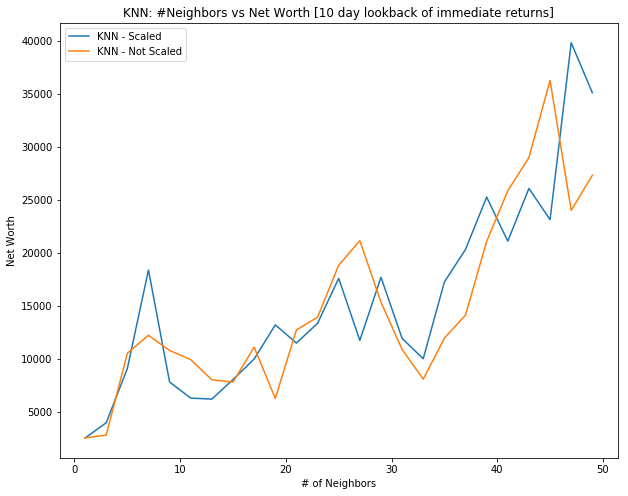

In [17]:
knnPlotX0 = fullMasterTable.loc[(fullMasterTable.Algorithm=='KNN')&(fullMasterTable.Scaled==0)
                                &(fullMasterTable.PrevDays==10)&(fullMasterTable.FeatsType==0),'Parameter']
knnPlotY0 = fullMasterTable.loc[(fullMasterTable.Algorithm=='KNN')&(fullMasterTable.Scaled==0)
                                &(fullMasterTable.PrevDays==10)&(fullMasterTable.FeatsType==0), 'Net Worth']
knnPlotY1 = fullMasterTable.loc[(fullMasterTable.Algorithm=='KNN')&(fullMasterTable.Scaled==1)
                                &(fullMasterTable.PrevDays==10)&(fullMasterTable.FeatsType==0), 'Net Worth']
figure(figsize=(10,8))
plt.plot(knnPlotX0,knnPlotY0)
plt.plot(knnPlotX0,knnPlotY1)
plt.legend(['KNN - Scaled','KNN - Not Scaled'],loc='upper left')
plt.ylabel('Net Worth')
plt.xlabel('# of Neighbors')
plt.title('KNN: #Neighbors vs Net Worth [10 day lookback of immediate returns]')
plt.show()

With a lookback of 10 days and immediate day prior returns, scaling the KNN model with StandardScaler doesn't produce a signficant and consistent change in the net worth generated.

##### Correlation matrix for the models generated with the standard 10-day immediate lookback 
The strongest correlation with 'Net Worth' is 'F1 score'. Looking at the top models based on their 'Net Worth', it is interesting to note that these do not have the highest 'F1 Score' however.

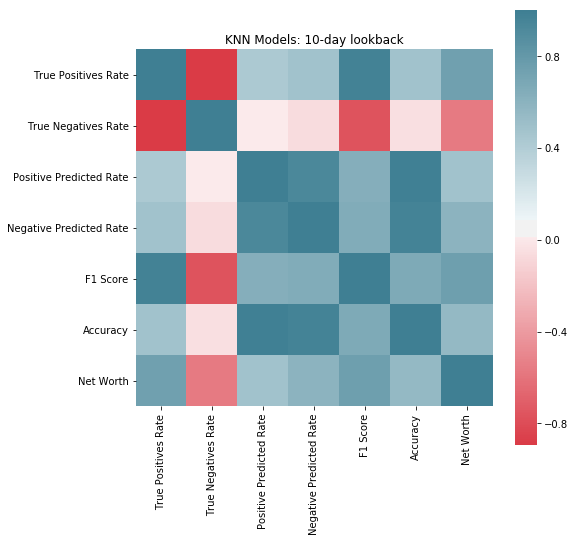

In [18]:
corr = knn10day.corr()
fig,fax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, cmap = sns.diverging_palette(10,220,as_cmap=True),
           square=True,
           ax=fax)
plt.title('KNN Models: 10-day lookback')
plt.show()

#####  Scatter plots of each of the metrics relative to net worth, in order to get a visual sense of the correlation

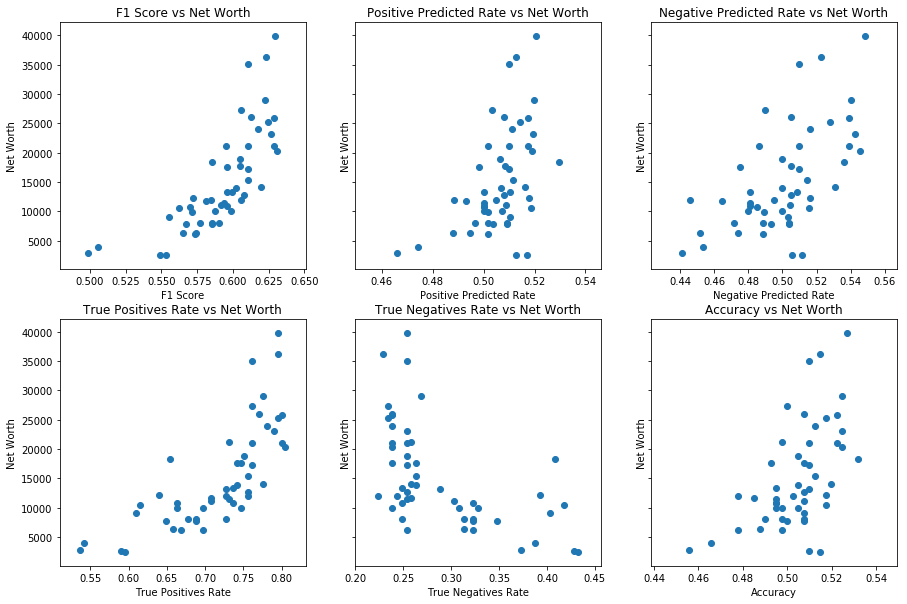

In [19]:
plt.figure()
fig, scats = plt.subplots(2,3,sharey=True, figsize=(15,10))
scats[0,0].scatter(knn10day['F1 Score'],knn10day['Net Worth'])
scats[0,0].set_title('F1 Score vs Net Worth')
scats[0,0].set_xlabel('F1 Score') 
scats[0,0].set_ylabel('Net Worth')
scats[0,1].scatter(knn10day['Positive Predicted Rate'],knn10day['Net Worth'])
scats[0,1].set_title('Positive Predicted Rate vs Net Worth')
scats[0,1].set_xlabel('Positive Predicted Rate') 
scats[0,1].set_ylabel('Net Worth')
scats[0,2].scatter(knn10day['Negative Predicted Rate'],knn10day['Net Worth'])
scats[0,2].set_title('Negative Predicted Rate vs Net Worth')
scats[0,2].set_xlabel('Negative Predicted Rate') 
scats[0,2].set_ylabel('Net Worth')
scats[1,0].scatter(knn10day['True Positives Rate'],knn10day['Net Worth'])
scats[1,0].set_title('True Positives Rate vs Net Worth')
scats[1,0].set_xlabel('True Positives Rate') 
scats[1,0].set_ylabel('Net Worth')
scats[1,1].scatter(knn10day['True Negatives Rate'],knn10day['Net Worth'])
scats[1,1].set_title('True Negatives Rate vs Net Worth')
scats[1,1].set_xlabel('True Negatives Rate') 
scats[1,1].set_ylabel('Net Worth')
scats[1,2].scatter(knn10day['Accuracy'],knn10day['Net Worth'])
scats[1,2].set_title('Accuracy vs Net Worth')
scats[1,2].set_xlabel('Accuracy') 
scats[1,2].set_ylabel('Net Worth')
plt.show()

#### - Comparing the KNN and LR models with 10-day returns:
##### Visualizing the daily investment value of natural market growth vs the KNN model with highest 'Net Worth' vs the Logistic Regression model with highest 'Net Worth':

In [132]:
df = setupDf('ethereum_dataset.csv')
knn10daycompare = marketReturnDailyCompare(df=df,algo='KNN',parameter=47,scaled=0,prevdays=10,feats=0)

In [130]:
knn10daycompare

,Date(UTC),eth_etherprice,tomorrowReturn,tomorrowPosNeg,tomorrowPredicted,Market Value,Algo Value
425,2016-09-27,13.09,0.006093,True,0.0,1000.000000,1000.000000
426,2016-09-29,13.17,0.009823,True,1.0,1006.111536,1006.111536
427,2016-09-28,13.30,-0.004521,False,1.0,1016.042781,1016.042781
428,2016-09-30,13.24,-0.002268,False,1.0,1011.459129,1011.459129
429,2016-10-01,13.21,0.001513,True,1.0,1009.167303,1009.167303
430,2016-10-02,13.23,0.016492,True,1.0,1010.695187,1010.695187
431,2016-10-03,13.45,-0.009712,False,1.0,1027.501910,1027.501910
432,2016-10-04,13.32,-0.017418,False,1.0,1017.570665,1017.570665
433,2016-10-05,13.09,-0.016950,False,1.0,1000.000000,1000.000000
434,2016-10-06,12.87,-0.014873,False,1.0,983.193277,983.193277


In [126]:
knn10dayalgos = pd.DataFrame(0,index=np.arange(len(tradenumbers)),columns=['trade analysis nums','market trade nums'])
for i in range(0,len(knn10dayalgos)):
    knn10dayalgos['trade analysis nums'].iloc[i]=knn10daycompare['Algo Value'].iloc[i]
usd = float(1000)
count =0
for i,j in tradenumbers:
    if i == True:
        usd*=np.exp(j)
    knn10dayalgos['market trade nums'].iloc[count]=usd
    count+=1

In [127]:
knn10dayalgos

,trade analysis nums,market trade nums
0,1000.000000,1000.000000
1,1006.111536,1006.111536
2,1016.042781,1016.042781
3,1011.459129,1011.459129
4,1009.167303,1009.167303
5,1010.695187,1010.695187
6,1027.501910,1027.501910
7,1017.570665,1017.570665
8,1000.000000,1000.000000
9,983.193277,983.193277


In [163]:
tradenumbers = performanceTable(df,'KNN',parameter=47,prevdays=10, feats=0)

In [165]:
tradenumbers.sort_values(by='Net Worth',ascending=False)

,Algorithm,Parameter,Scaled,PrevDays,FeatsType,True Positives Rate,True Negatives Rate,Positive Predicted Rate,Negative Predicted Rate,F1 Score,Accuracy,Net Worth
0,KNN,47,0,10,0,0.795122,0.253731,0.520767,0.548387,0.629344,0.527094,40721.184535
0,KNN,45,1,10,0,0.795122,0.228856,0.512579,0.522727,0.623327,0.514778,37082.712765
0,KNN,43,1,10,0,0.775610,0.268657,0.519608,0.540000,0.622309,0.524631,29644.453843
0,KNN,43,0,10,0,0.770732,0.238806,0.508039,0.505263,0.612403,0.507389,26664.625048
0,KNN,41,1,10,0,0.800000,0.238806,0.517350,0.539326,0.628352,0.522167,26438.765888
0,KNN,39,0,10,0,0.795122,0.233831,0.514196,0.528090,0.624521,0.517241,25832.174128
0,KNN,47,1,10,0,0.780488,0.238806,0.511182,0.516129,0.617761,0.512315,24547.802934
0,KNN,45,0,10,0,0.790244,0.253731,0.519231,0.542553,0.626692,0.524631,23658.768461
0,KNN,27,1,10,0,0.731707,0.258706,0.501672,0.485981,0.595238,0.497537,21624.488577
0,KNN,41,0,10,0,0.760976,0.253731,0.509804,0.510000,0.610568,0.509852,21582.589556


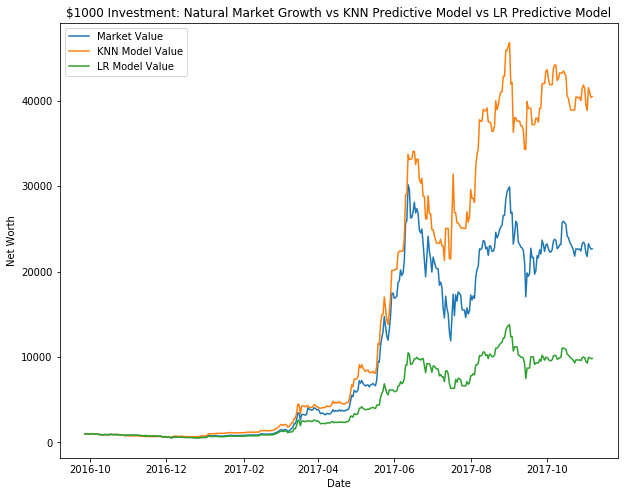

Buying $1000 at start of test and holding on without selling will produce a net worth: $22,675.32
Buying $1000 at start of test and using the 10-day unscaled KNN model will produce a net worth: $40,473.83
Buying $1000 at start of test and using the 10-day LR model will produce a net worth: $9,819.73


In [115]:
knn10dayX0 = knn10daycompare['Date(UTC)']
knn10dayY0 = knn10daycompare['Market Value']
knn10dayY1 = knn10daycompare['Algo Value']
lr10dayY0 = lr10daycompare['Algo Value']

figure(figsize=(10,8))
plt.plot(knn10dayX0,knn10dayY0)
plt.plot(knn10dayX0,knn10dayY1)
plt.plot(lr10dayX0,lr10dayY0)
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.legend(['Market Value','KNN Model Value','LR Model Value'], loc='upper left')
plt.title('$1000 Investment: Natural Market Growth vs KNN Predictive Model vs LR Predictive Model')
plt.show()

finalMarketVal = knn10daycompare['Market Value'].iloc[len(knn10daycompare)-1]
finalKNN10val = knn10daycompare['Algo Value'].iloc[len(knn10daycompare)-1]
finalLR10val = lr10daycompare['Algo Value'].iloc[len(lr10daycompare)-1]
print "Buying $1000 at start of test and holding on without selling will produce a net worth: ${0:,.2f}".format(finalMarketVal)
print "Buying $1000 at start of test and using the 10-day unscaled KNN model will produce a net worth: ${0:,.2f}".format(finalKNN10val)
print "Buying $1000 at start of test and using the 10-day LR model will produce a net worth: ${0:,.2f}".format(finalLR10val)

###### The KNN model using the 47 nearest neighbors, looking back at 10 days of immediate returns, and not scaled, produces a meaningfully greater return on investment than the natural market growth (buying on the first day and selling on last day). The Logistic Regression model with these parameters produces a worse return on investment than the natural market growth.

### - Analysis on KNN and LR models with addtional parameters tested:
##### Identifying the top KNN and LR models when different lookback windows are used for returns and different amounts of days looked back

In [81]:
topKNNmodels = fullMasterTable.loc[(fullMasterTable.Algorithm=='KNN')]
topKNNmodels.sort_values(by='Net Worth', ascending=False).head()

,Algorithm,Parameter,Scaled,PrevDays,FeatsType,True Positives Rate,True Negatives Rate,Positive Predicted Rate,Negative Predicted Rate,F1 Score,Accuracy,Net Worth
0,KNN,23,0,21,1,0.762376,0.396985,0.562044,0.622047,0.647059,0.581047,103761.457687
0,KNN,25,0,21,1,0.752475,0.391960,0.556777,0.609375,0.640000,0.573566,82887.614167
0,KNN,19,0,21,1,0.762376,0.326633,0.534722,0.575221,0.628571,0.546135,75550.542437
0,KNN,35,0,10,1,0.780488,0.283582,0.526316,0.558824,0.628684,0.534483,75133.165019
0,KNN,21,0,21,1,0.747525,0.356784,0.541219,0.581967,0.627859,0.553616,73288.510005


In [ ]:
knn21daycompare = marketReturnDailyCompare(df=df,algo='KNN',parameter=23,scaled=0,prevdays=21,feats=1)

In [82]:
topLRmodels = fullMasterTable.loc[(fullMasterTable.Algorithm=='LR')]
topLRmodels.sort_values(by='Net Worth', ascending=False).head()

,Algorithm,Parameter,Scaled,PrevDays,FeatsType,True Positives Rate,True Negatives Rate,Positive Predicted Rate,Negative Predicted Rate,F1 Score,Accuracy,Net Worth
0,LR,---,0,20,1,0.940594,0.160804,0.532213,0.727273,0.679785,0.553616,30318.105871
0,LR,---,0,21,1,0.930693,0.175879,0.534091,0.714286,0.678700,0.556110,26217.028896
0,LR,---,0,21,0,0.910891,0.190955,0.533333,0.678571,0.672761,0.553616,22857.829186
0,LR,---,0,22,1,0.865672,0.206030,0.524096,0.602941,0.652908,0.537500,19942.678594
0,LR,---,0,20,0,0.896040,0.185930,0.527697,0.637931,0.664220,0.543641,18126.741167
